## Load Libraries

In [2]:
import shutil
import random 
import math
from sklearn.cluster import KMeans

import numpy as np
import pandas as pd
import json

# PLotting
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Download Coco Dataset

In [3]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip 'annotations_trainval2017.zip'

--2021-12-27 17:52:00--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.130.131
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.130.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  16.1MB/s    in 17s     

2021-12-27 17:52:17 (14.6 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


# Load COCO Dataset

In [4]:
trainFile = open('/content/annotations/instances_train2017.json')
jsonData = json.load(trainFile)
print("keys",jsonData.keys())

keys dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [5]:
images_count = len(jsonData['images'])
boxes_count = len(jsonData['annotations'])
catergories = len(jsonData['categories'])



print('Number of images: ',images_count)
print('Number of bounding boxes: ', boxes_count)
print('Number of classes: ', catergories)

Number of images:  118287
Number of bounding boxes:  860001
Number of classes:  80


# Mapping class names to category ids

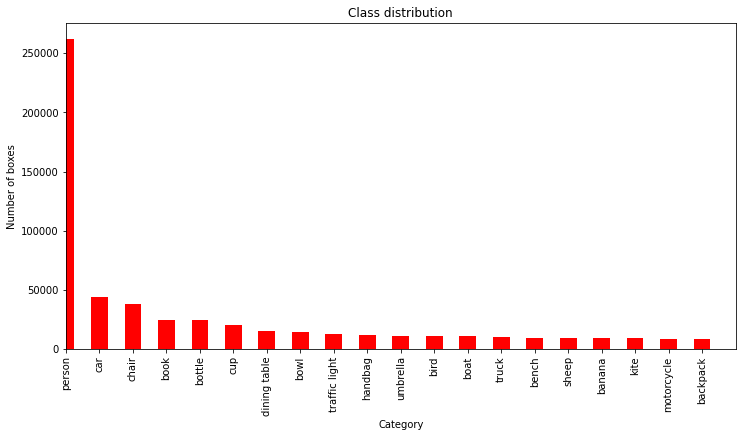

In [6]:
category_map = {}
for each_category in jsonData['categories']:
  category_id = each_category['id']
  category_name = each_category['name']
  category_map[category_id] = category_name

# Class distribution
class_to_bbox = {} 

for annotation in jsonData['annotations']:
    category_id = annotation['category_id']
    category_name = category_map[category_id]
    
    if category_name in class_to_bbox.keys():
        class_to_bbox[category_name] += 1
    else:
        class_to_bbox[category_name] = 1

bbox_class_sorted = [(k,v)for k, v in sorted(class_to_bbox.items(), reverse=True, key=lambda item: item[1])]

# Load first 20 class
class_20_sorted = min(len(bbox_class_sorted),20)


y = [i[1] for i in bbox_class_sorted[:class_20_sorted]]
x = [i[0] for i in bbox_class_sorted[:class_20_sorted]]

plt.figure(figsize=(12,6))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='red')
plt.xticks(rotation=90) 
plt.xlim(0,len(y))
plt.xlabel('Category')
plt.ylabel('Number of boxes')
plt.title('Class distribution')
plt.show()



# K-means Clustering for anchor boxes

In [30]:
# Sort the coco data
# Use Pandas dataframe for normalizing bounding boxes

# images DataFrame
images_df = pd.DataFrame(jsonData['images'], columns = jsonData['images'][0].keys())
print( images_df.head())
images_df.dropna()

# annotations DataFrame
annotations_df = pd.DataFrame(jsonData['annotations'], columns = jsonData['annotations'][0].keys())
print(annotations_df.head())

   license  ...      id
0        3  ...  391895
1        4  ...  522418
2        3  ...  184613
3        3  ...  318219
4        3  ...  554625

[5 rows x 8 columns]
                                        segmentation  ...    id
0  [[239.97, 260.24, 222.04, 270.49, 199.84, 253....  ...   156
1  [[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...  ...   509
2  [[274.58, 405.68, 298.32, 405.68, 302.45, 402....  ...   603
3  [[296.65, 388.33, 296.65, 388.33, 297.68, 388....  ...   918
4  [[251.87, 356.13, 260.13, 343.74, 300.39, 335....  ...  1072

[5 rows x 7 columns]


In [33]:
# #Extract the Box Dimensions
annotation_map_df = pd.concat([images_df, annotations_df], 1)[['file_name', 'width', 'height', 'bbox']]
box_df =pd.DataFrame(annotation_map_df['bbox'].values.tolist(), columns =['x', 'y', 'box_width', 'box_height'])
annotation_map_df = pd.concat([annotation_map_df, box_df], 1)
annotation_map_df = annotation_map_df.drop('bbox', axis =1)
annotation_map_df = annotation_map_df.dropna()
print(annotation_map_df.head())

          file_name  width  height       x       y  box_width  box_height
0  000000391895.jpg  640.0   360.0  199.84  200.46      77.71       70.88
1  000000522418.jpg  640.0   480.0  234.22  317.11     149.39       38.55
2  000000184613.jpg  500.0   336.0  239.48  347.87     160.00       57.81
3  000000318219.jpg  556.0   640.0  296.65  388.33       1.03        0.00
4  000000554625.jpg  426.0   640.0  251.87  333.42     125.94       22.71


In [35]:
# NOrmalize the BBOX values
normalize_annotations_map_df = annotation_map_df.copy()
normalize_annotations_map_df['x'] = annotation_map_df['x']/annotation_map_df['width']
normalize_annotations_map_df['y'] = annotation_map_df['y']/annotation_map_df['height']
normalize_annotations_map_df['box_width'] = annotation_map_df['box_width']/annotation_map_df['width']
normalize_annotations_map_df['box_height'] = annotation_map_df['box_height']/annotation_map_df['height']
normalize_annotations_map_df.head()

,file_name,width,height,x,y,box_width,box_height
0,000000391895.jpg,640.0,360.0,0.312250,0.556833,0.121422,0.196889
1,000000522418.jpg,640.0,480.0,0.365969,0.660646,0.233422,0.080312
2,000000184613.jpg,500.0,336.0,0.478960,1.035327,0.320000,0.172054
3,000000318219.jpg,556.0,640.0,0.533543,0.606766,0.001853,0.000000
4,000000554625.jpg,426.0,640.0,0.591244,0.520969,0.295634,0.035484


In [37]:
bbox_array = normalize_annotations_map_df[["box_width", "box_height"]].to_numpy()
bbox_array.shape

(118287, 2)

# K-means calculation


In [38]:
class Kmeans: # Taken from K-means class from EVA session
    def __init__(self, n_clusters, data_points, iterations):
        self.n_clusters = n_clusters
        self.data_points = data_points
        self.iterations = iterations

        self.cluster_centers,self.prediction,self.wcss = self.kmeans_clusters()
        # self.plot_anchor_boxes(self.cluster_centers)
 

    def IOU(self,x,centroids):
        '''
        :param x: a ground truth w,h
            :param centroids: collection of anchor w,h[(w,h),(),...], total k
            :return: a set of IoU values ​​for a single ground truth box and all k anchor boxes
        '''
        IoUs = []
        
        for centroid in centroids:
                w, h = x # ground truth's w, h
                c_w,c_h = centroid #anchorw,h
                # print(c_w,c_h)
                if c_w>=w and c_h>=h: #anchor surrounded by ground truth
                  iou = w*h/(c_w*c_h)
                elif c_w>=w and c_h<=h: #anchor
                  iou = w*c_h/(w*h + (c_w-w)*c_h)
                elif c_w<=w and c_h>=h: #anchor elongated
                  iou = c_w*h/(w*h + c_w*(c_h-h))
                else: #ground truth surrounded by anchor means both w,h are bigger than c_w and c_h respectively
                  iou = (c_w*c_h)/(w*h)
                IoUs.append(iou) # will become (k,) shape
        return np.array(IoUs)
  
    def avg_IOU(self,X):
        '''
            :param X: The set of w,h of ground truth[(w,h),(),...]
            :param centroids: collection of anchor w,h[(w,h),(),...], total k
        '''
        n,d = X.shape
        sum = 0.
        for i in range(X.shape[0]):
            sum+= max(self.IOU(X[i],self.cluster_centers)) #return a ground truth with the maximum value of all anchors in IoU
        return sum / X.shape[0]

    def kmeans_clusters(self): 
        
        kmeans = KMeans(n_clusters=self.n_clusters, init='k-means++', max_iter=self.iterations, n_init=10, random_state=0)
        pred_y = kmeans.fit_predict(self.data_points)
        return kmeans.cluster_centers_,pred_y,kmeans.inertia_        

    def plot_clusters(self):
        plt.scatter(self.data_points[:,0], self.data_points[:,1],c=self.prediction, cmap='viridis')
        plt.scatter(self.cluster_centers[:, 0], self.cluster_centers[:, 1], s=90, c='red')
        plt.xlabel('width')
        plt.ylabel('height')
        plt.title(f'Cluster Plot for k = {self.n_clusters}')
        plt.show()

    def plot_anchor_boxes(self):
        
        xdata = np.array([0.5]*len(self.cluster_centers))
        ydata = np.array([0.5]*len(self.cluster_centers))

        xerror = np.array([list(np.exp(self.cluster_centers[:, 0])/2)]*2)
        yerror = np.array([list(np.exp(self.cluster_centers[:, 1])/2)]*2)

        errorboxes = []

        for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
            rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
            errorboxes.append(rect)

        pc = PatchCollection(errorboxes, facecolor='None', alpha=1, edgecolor='r')
        fig, ax = plt.subplots(1)

        ax.add_collection(pc)
        plt.title(f'Anchor Boxes for k = {self.n_clusters}')
        artists = plt.errorbar(xdata, ydata, xerr=xerror, yerr=yerror, fmt='None', ecolor='None')

In [ ]:
# CLustering 

In [39]:
iou=[]
inertia = []
kmeans={}
cluster_range = range(3, 10)
for i in cluster_range:
  kmeans[i]=Kmeans(n_clusters = i,data_points = bbox_array,iterations = 300)
  iou.append(kmeans[i].avg_IOU(bbox_array))
  inertia.append(kmeans[i].wcss)

# CLusters vs IOU Plotting

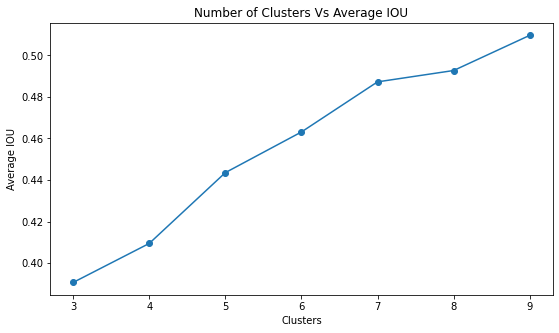

In [40]:
fig = plt.figure(figsize=(9, 5))
plt.plot(cluster_range, iou, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Average IOU')
plt.title("Number of Clusters Vs Average IOU")
plt.show()

# Anchor Box plotting for clusters

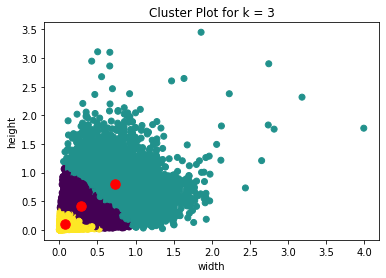

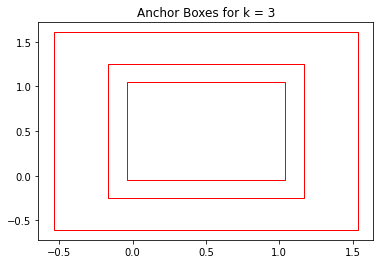

In [42]:
# K=3
k = 3
kmeans[k].plot_clusters()
kmeans[k].plot_anchor_boxes()

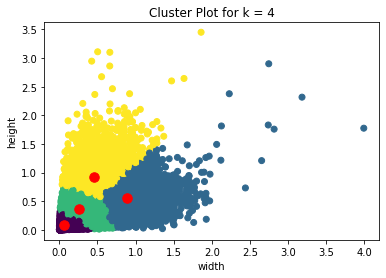

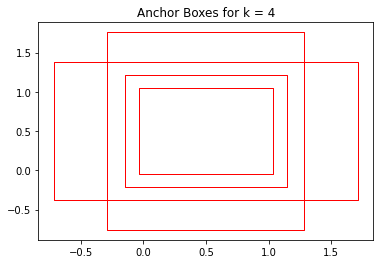

In [43]:
# K=4
k = 4
kmeans[k].plot_clusters()
kmeans[k].plot_anchor_boxes()

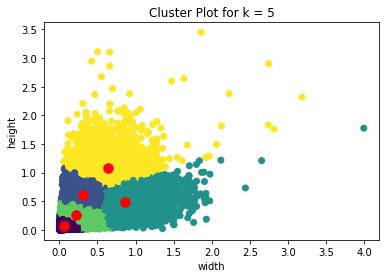

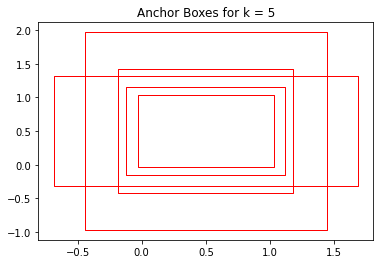

In [44]:
# K=5
k = 5
kmeans[k].plot_clusters()
kmeans[k].plot_anchor_boxes()

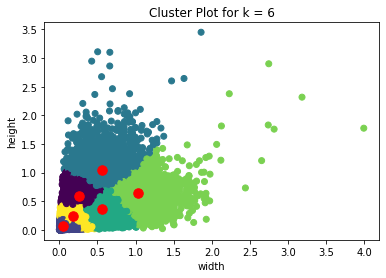

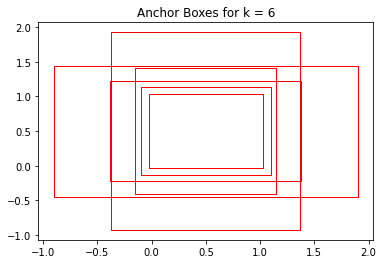

In [45]:
# K=6
k = 6
kmeans[k].plot_clusters()
kmeans[k].plot_anchor_boxes()